Moshe Kashlinsky,
Jonatan Yang, Aditya Gupta, Varsh Devired

**TODO READ ME: ADD A TITLE AND LEGEND AND AXES TO EVERY PLOT**

**INTRODUCTION**

The Federal Reserve is the central banking system of the United States created in 1913 with the goal of a safe and stable banking system. The Federal Reserve's responsibilities include creating and conducting national monetary policy, supervising and regulating banks, maintaining financial stability, and providing banking services to depository institutions and the federal government.

Monetary policy involves managing the supply of money in order to stabilize the economy. This includes controlling inflation, managing employment levels, and ensuring long-term interest rates. There are many ways the monetary police can alter the economy. The federal funds rate is the interest rate that banks use to borrow or lend needed reserves. The alteration of this key interest rate can influence economic activity, inflation and employment.

Unemployment refers to individuals who are capable of working, and are actively seeking work, are unable to find a job. The unemployment rate is an economic indicator, representing the percentage of the labor force that is unemployed. High unemployment indicates underutilized labor resources and can lead to lower economic output and increased social strain. On the other hand, very low unemployment can signal an overheated (a period of high productivity) economy and potentially lead to inflation. 

Interest rates, on the other hand, are the cost of borrowing money. They are a critical component of economic policy because they affect consumer spending, business investment, and overall economic growth. Lower interest rates tend to stimulate economic activity by making borrowing cheaper, while higher interest rates can slow down the economy by making borrowing more expensive. The Federal Reserve uses changes in the federal funds rate as a tool to influence other interest rates in the economy, including those for mortgages, loans, and savings accounts.

The relationship between the federal funds rate, unemployment, and inflation is a central topic in macroeconomics. In this study, we aim to examine whether changes in the federal funds rate have a measurable and predictable impact on unemployment and inflation. By analyzing historical data and employing econometric models, we seek to understand how the Federal monetary policy decisions influence these economic variables. The goal is to determine if changes to the federal funds rate has a measurable and predictable effect on unemployment and inflation.

Hypothesis: Changes in the federal funds rate have a significant and predictable impact on both unemployment and inflation. We expect that an increase in the federal funds rate will lead to higher unemployment and lower inflation, while a decrease in the federal funds rate will result in lower unemployment and higher inflation. This study will test this hypothesis by examining historical data on the federal funds rate, unemployment, and inflation, and analyzing the relationships between these variables using econometric models.

Sources:
https://www.federalreserve.gov/econres/notes/feds-notes/relationship-between-macroeconomic-overheating-and-financial-vulnerability-narrative-20181012.html
https://www.federalreserve.gov/econres/feds/unemployment-risk.htm
https://www.federalreserve.gov/monetarypolicy/files/FOMC20181019memo01.pdf
https://www.federalreserve.gov/econres/feds/files/2024032pap.pdf

**DATA CURATION**

First, we are going to import all our necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

Next, we import the databases from CSVs

In [2]:
fed_df = pd.read_csv("Raw Data/Federal Reserve/index.csv")
print(fed_df.head(10).to_markdown())

FileNotFoundError: [Errno 2] No such file or directory: 'Raw Data/Federal Reserve/index.csv'

Next, we will try to clean the data by seeing what is missing


In [ ]:
missing = fed_df.isnull().sum()
print(missing)

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate    152
Real GDP (Percent Change)       654
Unemployment Rate               152
Inflation Rate                  194
dtype: int64


Seems like quite a bit...

All we need to fix is the effective rate, the unemployment and inflation. We need to do only this since those are the main things that we will be using for our analysis. The Target, Upper and Lower rates are simply metrics that we will use to compute the effective rate, and Real GDP is by far mostly Null so is useless to us.

First, lets fix the Effective Federal Funds Rate. Let's see where we have missing values:


In [ ]:
print(fed_df[fed_df["Federal Funds Upper Target"].notnull() & fed_df["Federal Funds Lower Target"].isnull()])
print('\n')

print(fed_df[fed_df['Federal Funds Target Rate'].isnull() & fed_df['Federal Funds Upper Target'].isnull() & fed_df['Effective Federal Funds Rate'].isnull()].count())

Empty DataFrame
Columns: [Year, Month, Day, Federal Funds Target Rate, Federal Funds Upper Target, Federal Funds Lower Target, Effective Federal Funds Rate, Real GDP (Percent Change), Unemployment Rate, Inflation Rate]
Index: []


Year                            0
Month                           0
Day                             0
Federal Funds Target Rate       0
Federal Funds Upper Target      0
Federal Funds Lower Target      0
Effective Federal Funds Rate    0
Real GDP (Percent Change)       0
Unemployment Rate               0
Inflation Rate                  0
dtype: int64


From this, we can determine that wherever there is an Upper Target, there is also a lower target, and that we have no values where we have no Effective Federal Funds Rate, Federal Funds Target Rate, or Upper and Lower Targets, which means we can consolidate our data into one Effective Federal Funds Rate column. 

Where the Effective Federal Funds Rate is missing values, we will either impute it with the target rate, or impute it based on the average of the upper and lower rate depending if we don't have the target rate. 

In [ ]:
print(fed_df[pd.isnull(fed_df['Effective Federal Funds Rate'])].to_markdown())

# We can see from here that there are two cases: Either we have a target rate, or we have an upper and lower rate. We will calculate the federal funds rate as follows
# If we have the case of a Target Rate, set the effective rate to the target rate
# If we have the case of an upper and lower target, set the effective rate to the mean of the two.

debugList = fed_df[pd.isna(fed_df['Effective Federal Funds Rate']) & pd.isna(fed_df['Federal Funds Target Rate'])]

def fixEffectiveFundsRate(series):
    naArray = pd.isna(series)
    if(naArray['Effective Federal Funds Rate']):
        if(not naArray['Federal Funds Target Rate']):
            return series['Federal Funds Target Rate']
        elif(not(naArray['Federal Funds Upper Target'] or naArray['Federal Funds Lower Target'])):
            #print((series['Federal Funds Upper Target'] + series['Federal Funds Lower Target'])/2)
            return (series['Federal Funds Upper Target'] + series['Federal Funds Lower Target'])/2
        return "ERROR PLEASE EXAMINE"
    return series['Effective Federal Funds Rate']

fed_df['Effective Federal Funds Rate'] = fed_df.apply(fixEffectiveFundsRate, axis=1)

print("\n")

|     |   Year |   Month |   Day |   Federal Funds Target Rate |   Federal Funds Upper Target |   Federal Funds Lower Target |   Effective Federal Funds Rate |   Real GDP (Percent Change) |   Unemployment Rate |   Inflation Rate |
|----:|-------:|--------:|------:|----------------------------:|-----------------------------:|-----------------------------:|-------------------------------:|----------------------------:|--------------------:|-----------------:|
| 339 |   1982 |       9 |    27 |                     10.25   |                       nan    |                       nan    |                            nan |                         nan |                 nan |              nan |
| 341 |   1982 |      10 |     7 |                      9.5    |                       nan    |                       nan    |                            nan |                         nan |                 nan |              nan |
| 343 |   1982 |      11 |    19 |                      9      |            

**EXPLORATORY DATA ANALYSIS**

Next, let's see our missing values for unemployment. Since we have no other columns we can use specifically for imputation like we did with the funds rate, lets also plot the unemployment rate to see if there are any patterns or whether the missing values for unemployment are MAR (Missing at Random)

|     |   Year |   Month |   Day |   Federal Funds Target Rate |   Federal Funds Upper Target |   Federal Funds Lower Target |   Effective Federal Funds Rate |   Real GDP (Percent Change) |   Unemployment Rate |   Inflation Rate |
|----:|-------:|--------:|------:|----------------------------:|-----------------------------:|-----------------------------:|-------------------------------:|----------------------------:|--------------------:|-----------------:|
| 339 |   1982 |       9 |    27 |                     10.25   |                       nan    |                       nan    |                        10.25   |                         nan |                 nan |              nan |
| 341 |   1982 |      10 |     7 |                      9.5    |                       nan    |                       nan    |                         9.5    |                         nan |                 nan |              nan |
| 343 |   1982 |      11 |    19 |                      9      |            

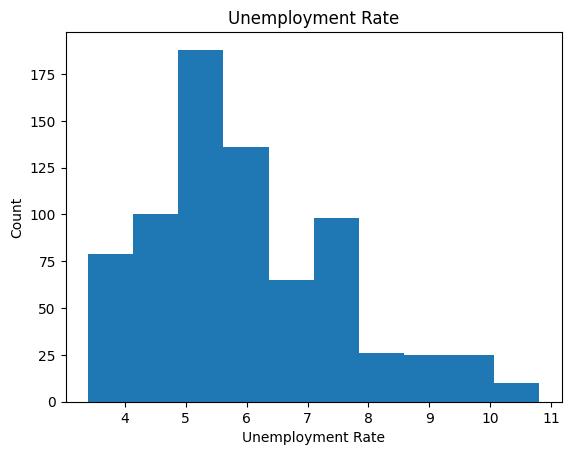

In [ ]:
print(fed_df[fed_df["Unemployment Rate"].isnull()].to_markdown())

plt.hist(fed_df["Unemployment Rate"])
plt.title("Unemployment Rate")
plt.xlabel("Unemployment Rate")
plt.ylabel("Count")
plt.show()

There doesn't seem to be any specific value of unemployment rate that is missing, and there doesn't seem to be any major gaps in the histogram, but let's also compare the unemployment data against the data by classifying it as either missing or not missing.

Text(0.5, 1.0, 'Federal Funds Rate vs Missing Values in Unemployment')

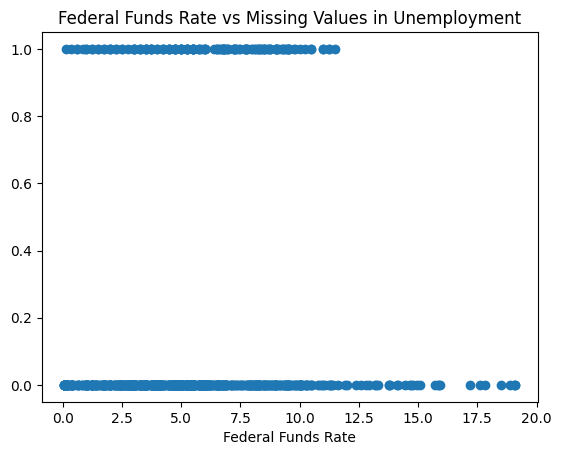

In [ ]:
missing_unemployment =  fed_df["Unemployment Rate"].isnull().apply(lambda x: 1 if x else 0)
plt.scatter(fed_df["Effective Federal Funds Rate"], missing_unemployment)
plt.xlabel("Federal Funds Rate")
plt.title("Federal Funds Rate vs Missing Values in Unemployment")

The missing data for unemployment also seem fairly evenly spread amongst various funds rates, so we can conclude that the missing data for unemployment is most likely Missing at Random

We can fill in the missing values for unemployment using via hotdeck imputation now that we have a series with no Null values (Effective Federal Funds Rate), meaning we will replace the value in rows that are missing an unemployment rate with a value that matches the majority value in rows with the same effective federal funds rate.

In [ ]:
print(fed_df[pd.isnull(fed_df['Unemployment Rate'])].to_markdown())
print('\n')

#We see that for every null unemployment, we have a null inflation as well. The only nonnull we have consistently is effective rate. The other non-null rates are the target, the lower and upper rate, but we only either have target or upper+lower.
# I will use hotdeck imputation to fill in the unemployments based on Effective Federal Funds Rate

grouped_unemployments = fed_df.groupby(['Effective Federal Funds Rate'])['Unemployment Rate'].apply(pd.Series.mode)
test = (grouped_unemployments.to_dict())
ordered_dict = {}
for i in test:
    if(i[0] not in ordered_dict):
        ordered_dict[i[0]] = []
    else:
        if(test[i] in ordered_dict[i[0]]):
            print("ERROR")
        ordered_dict[i[0]].append(test[i])

for i in fed_df['Effective Federal Funds Rate']:
    if(i in ordered_dict):
        pass
        #print(ordered_dict[i])
    else:
        ordered_dict[i] = []

for i in list(ordered_dict):
    if(ordered_dict[i]==[]):
        del ordered_dict[i]


def findClosestKey(dictionary,inputKey):
    if(inputKey in dictionary):
        return inputKey
    keys = dictionary.keys()
    toReturn = None
    for key in keys: # iterate through each key
        if(toReturn == None):
            toReturn = key
        if(abs(inputKey-key) < abs(inputKey-toReturn)): # if the current key is closer than our supposed closest, set this one as closest
            toReturn = key # set out new closest
    return toReturn

def fixUnemployment(series):
    naArray = pd.isna(series)
    if(naArray['Unemployment Rate']):
        key = findClosestKey(ordered_dict,series['Effective Federal Funds Rate'])
        return (sum(ordered_dict[key])/len(ordered_dict[key]))
    return series['Unemployment Rate']

fed_df['Unemployment Rate'] = fed_df.apply(fixUnemployment, axis=1)

|     |   Year |   Month |   Day |   Federal Funds Target Rate |   Federal Funds Upper Target |   Federal Funds Lower Target |   Effective Federal Funds Rate |   Real GDP (Percent Change) |   Unemployment Rate |   Inflation Rate |
|----:|-------:|--------:|------:|----------------------------:|-----------------------------:|-----------------------------:|-------------------------------:|----------------------------:|--------------------:|-----------------:|
| 339 |   1982 |       9 |    27 |                     10.25   |                       nan    |                       nan    |                        10.25   |                         nan |                 nan |              nan |
| 341 |   1982 |      10 |     7 |                      9.5    |                       nan    |                       nan    |                         9.5    |                         nan |                 nan |              nan |
| 343 |   1982 |      11 |    19 |                      9      |            

And finally, Inflation. We have two series with no null values, so we will again use hotdeck imputation to fix inflation. Since we have two columns and there may not be an exact match, we will use euclidean distance to find the MOST SIMILAR value to the inputted one.

In [ ]:
grouped_inflation = fed_df.groupby(['Effective Federal Funds Rate','Unemployment Rate'])['Inflation Rate'].agg(pd.Series.mode)
for index, value in grouped_inflation.items():
    if(value.size==0):
        grouped_inflation.pop(index)

def findNearestPoint(lst, input):
    distances = lst.index.map(lambda x: distance(x, input))
    return np.argmin(distances)

def distance(indexOne, indexTwo):
    return np.sqrt(sum((a - b) ** 2 for a, b in zip(indexOne, indexTwo)))

def fixInflation(series):
    naArray = pd.isna(series)
    if(naArray['Inflation Rate']):
        index = findNearestPoint(grouped_inflation, (series['Effective Federal Funds Rate'],series['Unemployment Rate']))
        result = grouped_inflation.iat[index]
        if(type(result)==np.ndarray):
            result = sum(result)/len(result)
        return result
    return series['Inflation Rate']

fed_df['Inflation Rate'] = fed_df.apply(fixInflation, axis=1)

Now that we have cleaned the data, lets check again whether we have any missing values.

In [ ]:
missing = fed_df.isnull().sum()
print(missing)

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate      0
Real GDP (Percent Change)       654
Unemployment Rate                 0
Inflation Rate                    0
dtype: int64


We have verified that we have no more null values in the Effective FF Rate, Unemployment and Inflation columns. The data is cleaned, now let's examine it.

First, let's plot out a box and whisker plot of each of the three series we have cleaned and see what we find:

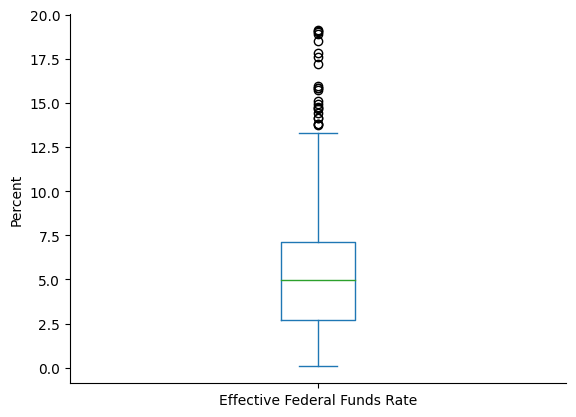

In [ ]:
plot= fed_df.plot(column="Effective Federal Funds Rate", kind= "box", ylabel="Percent")
plot.spines["right"].set_visible(False)
plot.spines["top"].set_visible(False)

We can clearly see that there are several outliers, starting after 12.5 - this could cause a few issues, but they are also authentic datapoints, and dropping them could give us inaccurate results

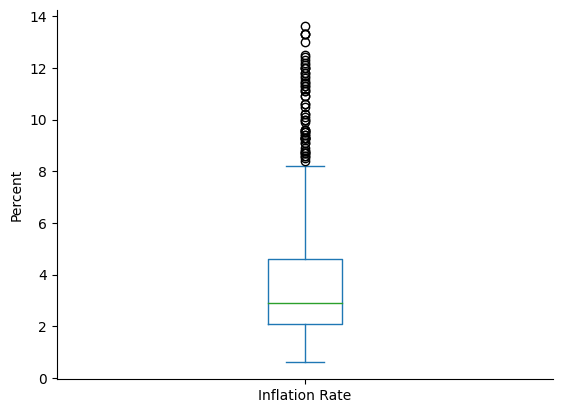

In [ ]:
plot = fed_df.plot(column="Inflation Rate", kind= "box", ylabel="Percent")
plot.spines["right"].set_visible(False)
plot.spines["top"].set_visible(False)

We can see that inflation has some more outliers, with values from 8-14. Again, these are authentic datapoints, and there is a worry of dropping them leading to problems later with hypothesis testing, so we will again keep the datapoints. However, it is good to know that there are outlier values for our analysis.

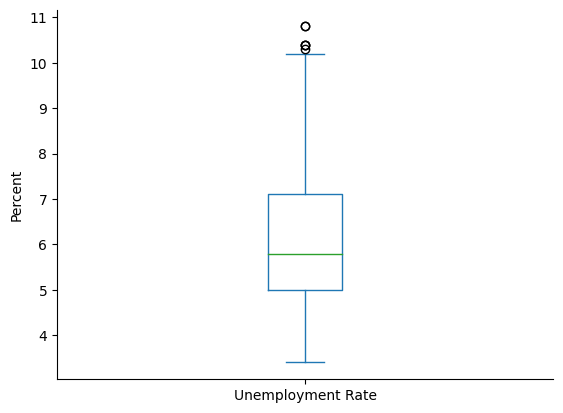

In [ ]:
plot = fed_df.plot(column="Unemployment Rate", kind= "box", ylabel="Percent")
plot.spines["right"].set_visible(False)
plot.spines["top"].set_visible(False)


Finally, we can see that unemployment has surprisingly few outliers - dropping them wouldn't help much, but perhaps would ruin the integrity of the data, so we will choose not to drop them.

Let us now get a cursory look at how unemployment and inflation each relate to the federal funds rate, the crux of our examination. We will do this by plotting them together and seeing how the relative changes look

r = 0.08917119453907327


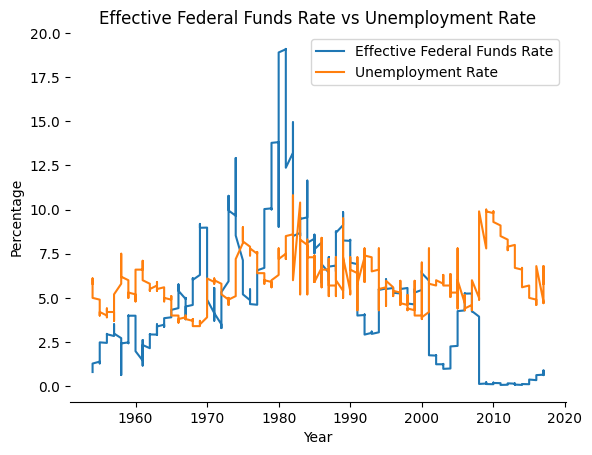

In [ ]:
plot = fed_df.plot(x='Year',y=['Effective Federal Funds Rate','Unemployment Rate'],kind='line', ylabel= "Percentage", title="Effective Federal Funds Rate vs Unemployment Rate")
plot.spines["right"].set_visible(False)
plot.spines["left"].set_visible(False)
plot.spines["top"].set_visible(False)
plot
correlation_coefficient =fed_df.corr('pearson')['Effective Federal Funds Rate']['Unemployment Rate'] 
print(f"r = {correlation_coefficient}")

r = 0.775446895986524


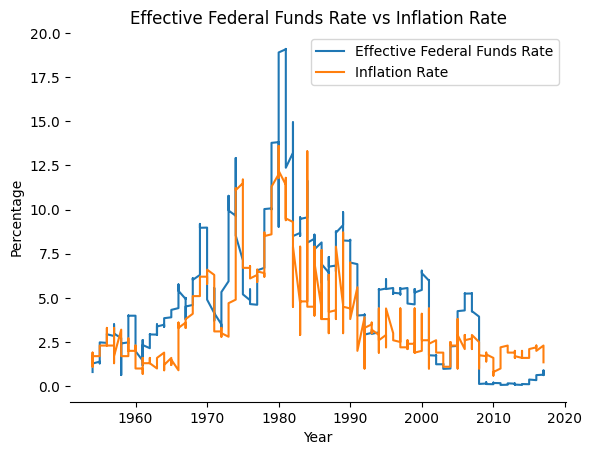

In [ ]:
plot = fed_df.plot(x='Year',y=['Effective Federal Funds Rate','Inflation Rate'],kind='line', ylabel= "Percentage", title="Effective Federal Funds Rate vs Inflation Rate")
plot.spines["right"].set_visible(False)
plot.spines["left"].set_visible(False)
plot.spines["top"].set_visible(False)
correlation_coefficient =fed_df.corr('pearson')['Effective Federal Funds Rate']['Inflation Rate'] 
print(f"r = {correlation_coefficient}")

At a cursory glance, it seems that inflation and the effective rate are very strongly related. One can see immediately that as the effective FF rate rises, so does the inflation rate. This shows a direct relation, which is supported the correlation coefficient of .784. However, unemployment does not seem as strongly related, as shown by the low correlation coefficient of .036, and will need a more in depth review to see what exactly is going on under the hood. With the exception of after the 2008 recession, the data looks like it could have a relationship, albeit weaker than inflation.

Next, lets plot the data out in a scatterplot

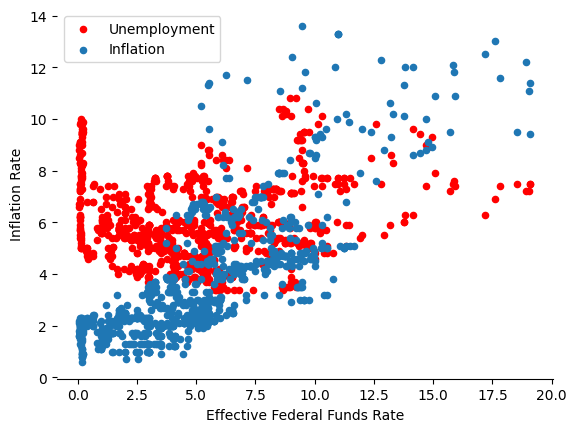

In [ ]:
ax = fed_df.plot.scatter(x='Effective Federal Funds Rate',y='Unemployment Rate',color='red',label='Unemployment',legend=True)
plot = fed_df.plot.scatter(x='Effective Federal Funds Rate',y='Inflation Rate',label='Inflation',legend=True,ax=ax)
plot.spines["right"].set_visible(False)
plot.spines["left"].set_visible(False)
plot.spines["top"].set_visible(False)


So we notice several things from this scatterplot. Firstly, we notice that there is a significant amount of zeroes in our inflation datapoints. Many of the values are clustered at FF=0, and this influences everything from our mean to our standard deviation, and potentially impacts models. Below, lets see how many values are at 0. Keep in mind we only have 903 values in our entire table.

In [ ]:
fed_df[fed_df['Effective Federal Funds Rate']==0].shape[0]

0

Interesting! While we dont seem to have ANY values at x=0, we have many which are still almost 0. What if we do a check where values are <0.25?

In [ ]:
fed_df[fed_df['Effective Federal Funds Rate']<=0.25].shape[0]

86

Now we see that we have 86 values with FF rates below 0.25, almost 10% of our data, we can see that we have a huge bias here. But how about the outliers? We can clearly see that the vast majority of the datapoints are with a federal funds rate below 12.5, but there are some that are almost 20. However, just by a quick inspection, we can see that the outliers are not too significant. Most of the points that are far out are following the general trend, so the only points that are really outliers are not going to have too much of an impact. This may or may not be a boundary condition, since it is not exactly zero, but it does tend to cluster there.

Before we run any hypothesis tests, we can see clearly that there is a correlation between inflation and the federal funds rate. But the unemployment rate seems to be less obviously correlated. At first glance, the two groups appear disparate, with a slight positive, albeit noisy, correspondence. This seems to be in line with common conceptions of the the federal funds rate and its relation with the economy as a whole. Let's do hypothesis testing and see how they are related here statistically.



> H0 - The Federal Funds Rate has NO impact on the Unemployment Rate




> HA - The Federal Funds Rate DOES have an impact on the Unemployment Rate

In this evaluation we shall use an alpha value of 0.05.



(45187.31893682355, 1.692741910395266e-73, 39858, array([[0.04977876, 0.04424779, 0.00553097, ..., 0.00553097, 0.01659292,
        0.01106195],
       [0.06969027, 0.0619469 , 0.00774336, ..., 0.00774336, 0.02323009,
        0.01548673],
       [0.12942478, 0.11504425, 0.01438053, ..., 0.01438053, 0.04314159,
        0.02876106],
       ...,
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239]]))


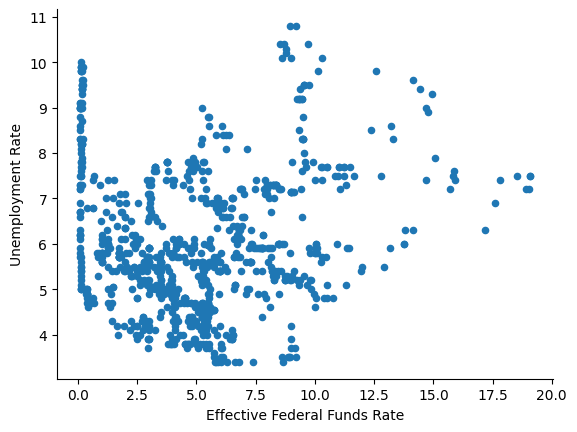

In [ ]:
unemployment_crosstable = pd.crosstab(fed_df['Effective Federal Funds Rate'], fed_df['Unemployment Rate'])
result = stats.chi2_contingency(unemployment_crosstable)
print(result) # the 2nd value is the p value
unemployment_plot = fed_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Unemployment Rate')
unemployment_plot.spines["right"].set_visible(False)
unemployment_plot.spines["top"].set_visible(False)

The p value for here is miniscule, implying that the two values are strongly related. The spike of zero-valued fund rates is visually denoted in the plot, forming a vertical bar across nearly the entire band of unemployment rates, and is a possible confounding variable we shall address shortly. Aside from this the plot describes a number of other more loosely correlated vertical patterns when the fund rate is approximately 3 and 9 percent respectively, though it is more difficult to draw any substantial conclusions if we consider them as outliers. Barring any further analysis, of course, what appears to be a tentative positive correlation visually persists.

Under hotdeck imputation, since a p-value of $~1.7*10^{-73}$ is significantly less than alpha (0.05), we may reject the null hypothesis, taking the alternative hypothesis as its replacement. Now, let us test inflation the same way.



> H0 - The Federal Funds Rate has NO impact on the Inflation Rate

> HA - The Federal Funds Rate DOES have an impact on the Inflation Rate



(72221.00072380164, 0.0, 54677, array([[0.00553097, 0.01106195, 0.01659292, ..., 0.00553097, 0.01659292,
        0.00553097],
       [0.00774336, 0.01548673, 0.02323009, ..., 0.00774336, 0.02323009,
        0.00774336],
       [0.01438053, 0.02876106, 0.04314159, ..., 0.01438053, 0.04314159,
        0.01438053],
       ...,
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00331858,
        0.00110619]]))


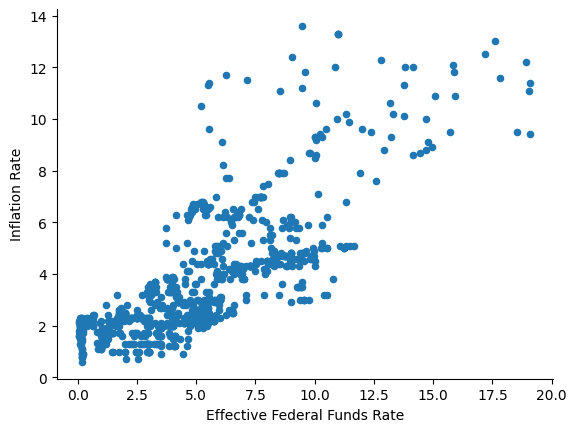

In [ ]:
inflation_crosstable = pd.crosstab(fed_df['Effective Federal Funds Rate'], fed_df['Inflation Rate'])
result = stats.chi2_contingency(inflation_crosstable)
print(result) # the 2nd value is the p value
inflation_plot = fed_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Inflation Rate')
inflation_plot.spines["right"].set_visible(False)
inflation_plot.spines["top"].set_visible(False)

The p value for here is the perfect positive correlation of zero (0.0), implying that the two values are strongly related. Unlike its counterpart scatterplot with unemployment rates, the federal funds rate has a less pronounced vertical bar of values near the origin, and a far more defined positive linear trend. Though we shall consider and address its zero values as a possible confounder in the following sections, an undeniable correlation remains as expected.

Under hotdeck imputation, since the p-value (0.0) is less than that of alpha (0.05), we may reject the null hypothesis and take the alternative hypothesis as its replacement.

We turn our attention to the problem of zero-value fund rate data points, and its possible presence as a confounding variable when determining a correlating relation between datasets.
hotdeck imputation is a powerful tool assuming a continuous distribution with a strong emphasis on the majority. In our analysis thus far, this has been our working assumption, and the data has been processed with hotdeck imputation. However, it may introduce heavy biases when any outliers are involved, as any NaN/null entries corresponding to one will simply duplicate outlying values with no regard to the rest of the data, resulting in misleading spikes. This is one possible explanation for the vertical bars around certain values in our plots, most notably around the origin. In light of this, we must test our hypotheses again, either with a number of different imputation methods or by simply dropping the offending NaN/null values.

First, we will try the simple approach. Let us try to drop Null values instead of imputing them and see if this affects our hypothesis testing. This time, we begin with the inflation rate.

In [ ]:
fed_nonnull_df = pd.read_csv("Raw Data/Federal Reserve/index.csv")
fed_nonnull_df = fed_nonnull_df.dropna(subset=['Effective Federal Funds Rate','Unemployment Rate','Inflation Rate'])
print(fed_nonnull_df.isnull().sum())


Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       395
Federal Funds Upper Target      612
Federal Funds Lower Target      612
Effective Federal Funds Rate      0
Real GDP (Percent Change)       474
Unemployment Rate                 0
Inflation Rate                    0
dtype: int64


We have verified that we have no more null values in our desired columns (Effective Federal Funds Rate, Unemployment Rate and Inflation Rate), so let us conduct hypothesis testing here.



> H0 - The Federal Funds Rate has NO impact on the Inflation Rate


> HA - The Federal Funds Rate DOES have an impact on the Inflation Rate

As before, we set an alpha value of 0.05.



(54625.57824755772, 5.408463068011238e-144, 46410, array([[0.00704225, 0.01408451, 0.02112676, ..., 0.00704225, 0.00704225,
        0.00704225],
       [0.00985915, 0.01971831, 0.02957746, ..., 0.00985915, 0.00985915,
        0.00985915],
       [0.01830986, 0.03661972, 0.05492958, ..., 0.01830986, 0.01830986,
        0.01830986],
       ...,
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845],
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845],
       [0.00140845, 0.0028169 , 0.00422535, ..., 0.00140845, 0.00140845,
        0.00140845]]))


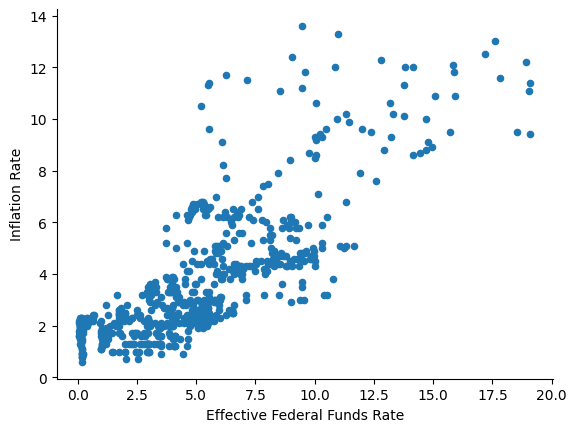

In [ ]:
inflation_second_crosstable = pd.crosstab(fed_nonnull_df['Effective Federal Funds Rate'], fed_nonnull_df['Inflation Rate'])
result = stats.chi2_contingency(inflation_second_crosstable)
print(result) # the 2nd value is the p value
inflation_second_plot = fed_nonnull_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Inflation Rate')
inflation_second_plot.spines["right"].set_visible(False)
inflation_second_plot.spines["top"].set_visible(False)

The p value for here is incredibly miniscule, implying that the two values are strongly correlated, as we found in our earlier analysis. The plot retains much of its visual appearance, including the spike at the origin. Unlike before, we may safely conclude that this is not an artifact of preprocessing but a property of the data itself. A subsequent analysis of the same pattern but with unemployment instead will elucidate its presence here.

Dropping null values, because p ($5.4*10^{-144}$) is less than alpha (0.05), we can confidently reject the null hypothesis and take the alternative hypothesis as its replacement. Now, let us test unemployment the same way.

> H0 - The Federal Funds Rate has NO impact on the Unemployment Rate

> HA - The Federal Funds Rate DOES have an impact on the Unemployment Rate
alpha = 0.05

(30520.626727085353, 0.954569245406529, 30940, array([[0.06338028, 0.05633803, 0.00704225, ..., 0.00704225, 0.02112676,
        0.01408451],
       [0.08873239, 0.07887324, 0.00985915, ..., 0.00985915, 0.02957746,
        0.01971831],
       [0.16478873, 0.14647887, 0.01830986, ..., 0.01830986, 0.05492958,
        0.03661972],
       ...,
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ],
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ],
       [0.01267606, 0.01126761, 0.00140845, ..., 0.00140845, 0.00422535,
        0.0028169 ]]))


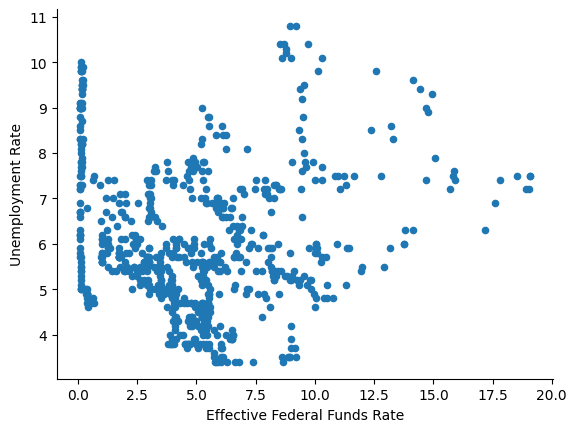

In [ ]:
unemployment_second_crosstable = pd.crosstab(fed_nonnull_df['Effective Federal Funds Rate'], fed_nonnull_df['Unemployment Rate'])
result = stats.chi2_contingency(unemployment_second_crosstable)
print(result) # the 2nd value is the p value
unemployment_second_plot = fed_nonnull_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Unemployment Rate')
unemployment_second_plot.spines["right"].set_visible(False)
unemployment_second_plot.spines["top"].set_visible(False)

The p value for here is surprising. It is roughly 0.95, implying that the null hypothesis is very strong when we drop null values. When dropping null values, since p (~0.95) is far greater than alpha (0.05), we can confidently fail to reject the null hypothesis and do not take the alternative hypothesis as its replacement.

With the non-null data from unemployment, it appears as if the slight positive trend is not enough to count as correlation. A visual comparison does not yield any insights. Why the dramatic 180? One possibility is that hotdeck imputation did in fact create a significant bias in the data, but that it did not have a connection with the prominent data spikes located throughout the graph, as their patterns persist even when removing all invalid data.

(As an aside, it is notable that federal fund rates have only been near zero for two major incidents in recent history: the 2008 recession and the 2020 pandemic. This is why the zero-spike does not dip below 4% unemployment.)


So we have a consensus on inflation, but how about unemployment? We are 1 for 1, so let us try a third method of imputation, MICE Imputation, and then see what happens.

We will now try to break the tie and see whether unemployment is linked to the federal funds rate. We are changing up the process by cleaning data in a 3rd way, using MICE imputation. MICE imputation and other regressive ML algorithms have a reputation for accuracy, preserving the distribution which it predicts. Let us see how it works out.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=100, max_iter=10) # Default learning rates

fed_mice_df = pd.read_csv("Raw Data/Federal Reserve/index.csv")

fed_train_df = fed_mice_df.loc[:, ['Effective Federal Funds Rate', 'Unemployment Rate','Inflation Rate']]
imputer.fit(fed_train_df)
fed_imputed_df = imputer.transform(fed_train_df)
fed_mice_df.loc[:, ['Effective Federal Funds Rate', 'Unemployment Rate','Inflation Rate']] = fed_imputed_df
fed_mice_df.isnull().sum()

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate      0
Real GDP (Percent Change)       654
Unemployment Rate                 0
Inflation Rate                    0
dtype: int64

We have verified that we have no more null values in our desired columns (Effective Federal Funds Rate, Unemployment Rate and Inflation Rate), so let us conduct hypothesis testing here. In the interest of experimentation, let us also test inflation and see whether we confirm our previous findings.

> H0 - The Federal Funds Rate has NO impact on the Inflation Rate

> HA - The Federal Funds Rate DOES have an impact on the Inflation Rate

As before, we set an alpha value of 0.05.

(95713.51976280363, 0.0, 68502, array([[0.00553097, 0.01106195, 0.01659292, ..., 0.00553097, 0.00553097,
        0.00553097],
       [0.00774336, 0.01548673, 0.02323009, ..., 0.00774336, 0.00774336,
        0.00774336],
       [0.01438053, 0.02876106, 0.04314159, ..., 0.01438053, 0.01438053,
        0.01438053],
       ...,
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00110619,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00110619,
        0.00110619],
       [0.00110619, 0.00221239, 0.00331858, ..., 0.00110619, 0.00110619,
        0.00110619]]))


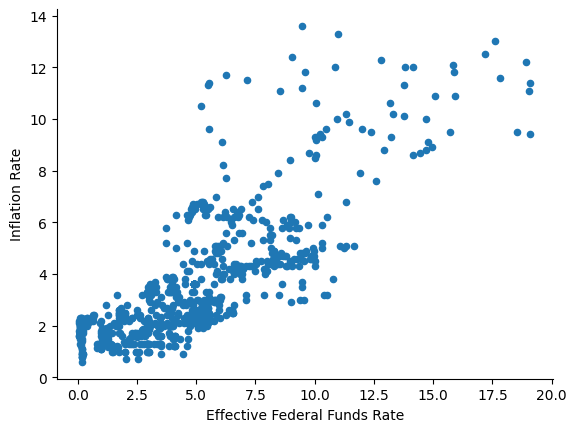

In [ ]:
inflation_third_crosstable = pd.crosstab(fed_mice_df['Effective Federal Funds Rate'], fed_mice_df['Inflation Rate'])
result = stats.chi2_contingency(inflation_third_crosstable)
print(result) # the 2nd value is the p value
inflation_third_plot = fed_mice_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Inflation Rate')
inflation_third_plot.spines["right"].set_visible(False)
inflation_third_plot.spines["top"].set_visible(False)

Confirming the last two tests, the p value for here indicates a perfect correlation, implying that the two values are related. Now, let us test unemployment the same way.

> H0 - The Federal Funds Rate has NO impact on the Unemployment Rate

> HA - The Federal Funds Rate DOES have an impact on the Unemployment Rate

(39705.819486285196, 1.2117909189757412e-129, 33086, array([[0.04977876, 0.04424779, 0.00553097, ..., 0.00553097, 0.01659292,
        0.01106195],
       [0.06969027, 0.0619469 , 0.00774336, ..., 0.00774336, 0.02323009,
        0.01548673],
       [0.12942478, 0.11504425, 0.01438053, ..., 0.01438053, 0.04314159,
        0.02876106],
       ...,
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239],
       [0.00995575, 0.00884956, 0.00110619, ..., 0.00110619, 0.00331858,
        0.00221239]]))


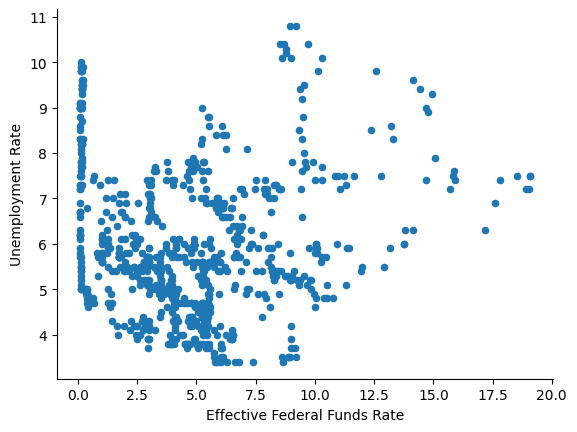

In [ ]:
unemployment_third_crosstable = pd.crosstab(fed_mice_df['Effective Federal Funds Rate'], fed_mice_df['Unemployment Rate'])
result = stats.chi2_contingency(unemployment_third_crosstable)
print(result) # the 2nd value is the p value
unemployment_third_plot = fed_mice_df.plot(kind='scatter',x='Effective Federal Funds Rate',y='Unemployment Rate')
unemployment_third_plot.spines["right"].set_visible(False)
unemployment_third_plot.spines["top"].set_visible(False)

The p value for here is tiny, implying that the two values are related. As before, a direct visual comparison yields no insight. Since p (~1.2*10^-129) is less than alpha (0.05), we should confidently reject the null hypothesis and take the alternative hypothesis as its replacement. However, this could just be due lack of information: overfitting on outliers can easily lead to a misleading conclusion, in much the same way as hotdeck imputation.

In addition to this, we may need to reexamine our findings quantitatively. The Chi Square test delineates the relationship between two categorical variables; which for a visibly strong relationship such as the one between inflation and fund rates may function properly by sorting a small number of data points per 'category'; though the same might not be said if the data points are more randomly distributed.

To follow up, we shall use direct correlation testing across all datasets to conclusively determine whether there is a relationship or not between unemployment and the federal funds rate.

Let us now finally calculate the correlations of the federal funds rate to unemployment and inflation respectively. Here, we shall use the Pearson correlation method.

In [ ]:
print(f"Inflation: {fed_df['Effective Federal Funds Rate'].corr(fed_df['Inflation Rate'])}")
print(f"Unemployment 1: {fed_df['Effective Federal Funds Rate'].corr(fed_df['Unemployment Rate'])}")
print(f"Unemployment 2: {fed_nonnull_df['Effective Federal Funds Rate'].corr(fed_nonnull_df['Unemployment Rate'])}")
print(f"Unemployment 3: {fed_mice_df['Effective Federal Funds Rate'].corr(fed_mice_df['Unemployment Rate'])}")

Inflation: 0.775446895986523
Unemployment 1: 0.08917119453907305
Unemployment 2: -0.0016378031245195897
Unemployment 3: 0.03662592946489293


We can conclude here that the Federal Funds Rate has a VERY strong positive correlation to inflation. However, the results for unemployment are different. In all three methods of checking whether there is a correlation between the federal funds rate and unemployment, the correlation coefficient does not even get higher than ±0.1 - this implies that there is very little, if any correlation between the federal funds rate and unemployment.


This latest finding is in line with a visual analysis: it is not likely that the federal funds rate is as heavily correlated with unemployment as it is with inflation from a simple comparison! Instead, the imputation methods amplified the common data points enough that a categorical redistribution of the processed data points would easily result in a misleading high correlation. With a quantitative analysis through the Pearson method, we reach a more appropriate and intuitive final result.

In conclusion, based on our analysis of the data, there is a strong correlation between inflation and the federal funds rate, while there is little to no correlation between unemployment and the federal funds rate.

**PRIMARY ANALYSIS**

From the rubric

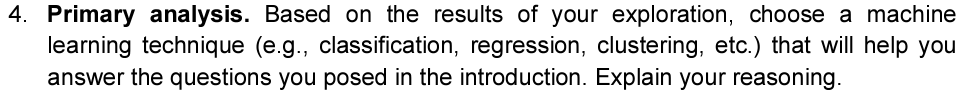

Linear trend with inflation, use linear regression to find pattern. **WRITE A PARAGRAPH TO EXPLAIN WHY**. Verify train and test data

**TODO: PLEASE ELABORATE ON ALL MY COMMANDS BELOW - THEY ARE KINDA BAREBONES**

From the examination above, there is a much stronger chance that inflation has a linear relationship with the Federal Funds Rate than Unemployment. Lets try to first use linear regression on inflation, and then confirm later with a Neural Network. In addition, lets use a Neural Network to see if there is any kind of relationship between Unemployment and the Federal Funds Rate.

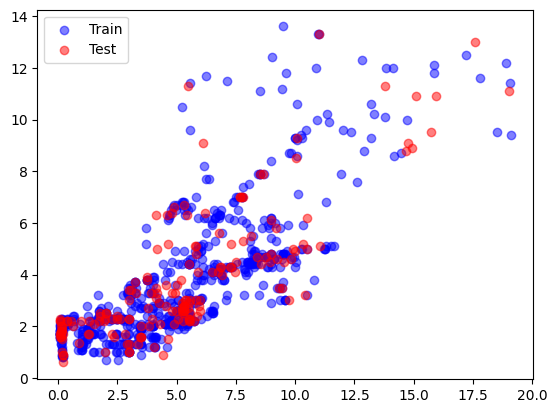

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_inflation_train, X_inflation_test, Y_inflation_train, Y_inflation_test = train_test_split(fed_df["Effective Federal Funds Rate"].to_numpy().reshape(-1,1), fed_df["Inflation Rate"].to_numpy().reshape(-1,1),test_size=0.2)

plt.scatter(X_inflation_train,Y_inflation_train,color='blue',label='Train',alpha=0.5)
plt.scatter(X_inflation_test,Y_inflation_test,color='red',label='Test',alpha=0.5)
plt.legend()
plt.show()

It seems that both the test and train cases make a fair representation of the data - lets proceeed to make a model.

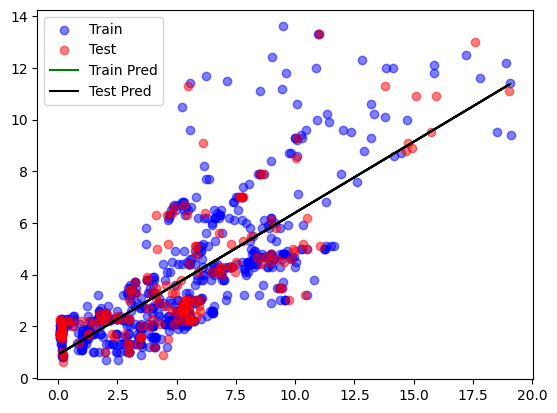

In [ ]:
inflation_model = LinearRegression()

Y_inflation_train_pred = inflation_model.fit(X_inflation_train,Y_inflation_train).predict(X_inflation_train)
Y_inflation_test_pred = inflation_model.predict(X_inflation_test)

plt.scatter(X_inflation_train,Y_inflation_train,color='blue',label='Train',alpha=0.5)
plt.scatter(X_inflation_test,Y_inflation_test,color='red',label='Test',alpha=0.5)
plt.plot(X_inflation_train,Y_inflation_train_pred,color='green',label='Train Pred')
plt.plot(X_inflation_test,Y_inflation_test_pred,color='black',label='Test Pred')
plt.legend()
plt.show()

It seems like the line gets the general shape somewhat well, but it doesnt really account for the outliers or for the variation. In addition, it looks like the data starts to curve upwards more quickly as you increase the Federal Funds Rate, potentially implying a polynomial relationship. Lets see what the error is for the standard linear regression - from this we can determine whether a straight line is a good fit.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse_inflation_train = mean_squared_error(Y_inflation_train,Y_inflation_train_pred)
mse_inflation_test = mean_squared_error(Y_inflation_test,Y_inflation_test_pred)
r2_inflation_train = r2_score(Y_inflation_train,Y_inflation_train_pred)
r2_inflation_test = r2_score(Y_inflation_test,Y_inflation_test_pred)

print(f"  MSE Train: {mse_inflation_train:.4f}")
print(f"  MSE Test: {mse_inflation_test:.4f}")
print(f"  R2 Train: {r2_inflation_train:.4f}")
print(f"  R2 Test: {r2_inflation_test:.4f}")

  MSE Train: 2.4434
  MSE Test: 2.2936
  R2 Train: 0.5935
  R2 Test: 0.6311


It seems that just a standard linear line doesnt work too well to predict this. It could very well be due to the variation in the data, but lets see if we can introduce polynomial features into the model and get a better result without overfitting.

Train - MSE: 2.3041, R^2: 0.6096
Test - MSE: 2.7404, R^2: 0.5783



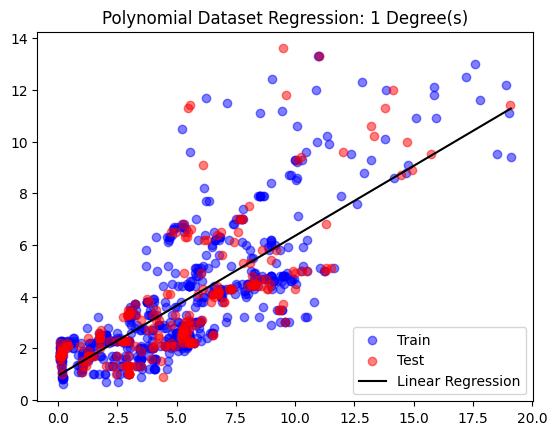

Train - MSE: 2.4221, R^2: 0.6103
Test - MSE: 2.1232, R^2: 0.6144



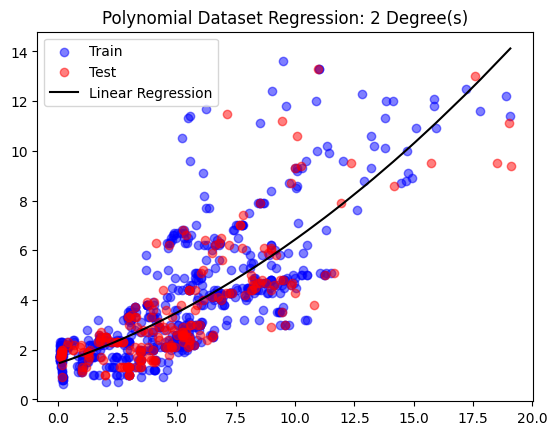

Train - MSE: 2.3332, R^2: 0.6082
Test - MSE: 2.1446, R^2: 0.6619



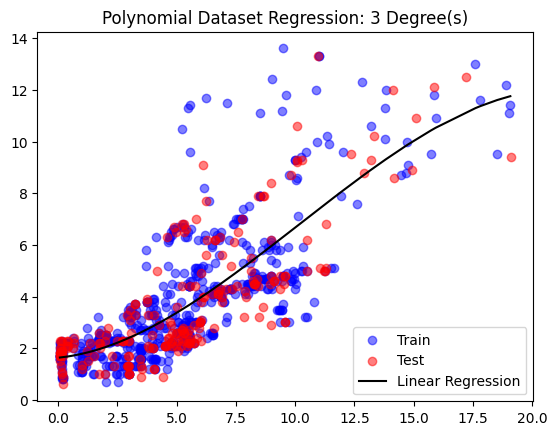

Train - MSE: 2.3013, R^2: 0.6357
Test - MSE: 2.2518, R^2: 0.5716



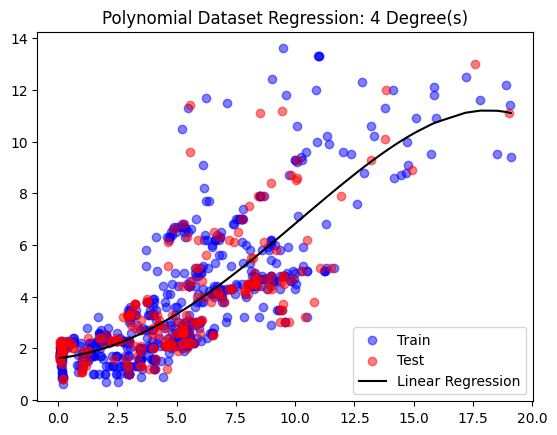

Train - MSE: 2.3022, R^2: 0.6199
Test - MSE: 2.1291, R^2: 0.6450



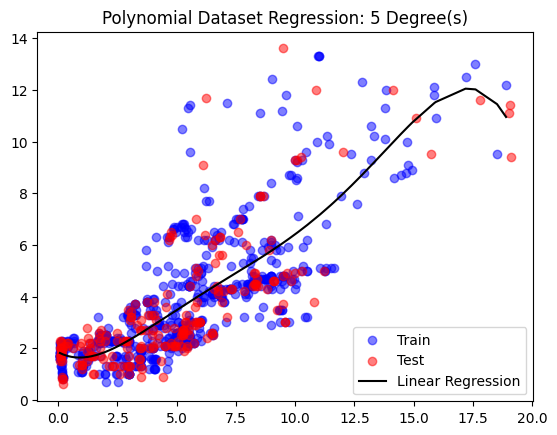

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
def PolynomialTest(degrees):
    model = make_pipeline(PolynomialFeatures(degrees), LinearRegression())
    X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(fed_df["Effective Federal Funds Rate"].to_numpy().reshape(-1,1), fed_df["Inflation Rate"].to_numpy().reshape(-1,1))
    y_train_pred = model.fit(X_poly_train,y_poly_train).predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)
    print(f"Train - MSE: {mean_squared_error(y_poly_train,y_train_pred):.4f}, R^2: {r2_score(y_poly_train,y_train_pred):.4f}")
    print(f"Test - MSE: {mean_squared_error(y_poly_test,y_test_pred):.4f}, R^2: {r2_score(y_poly_test,y_test_pred):.4f}\n")
    X_poly_train_sorted_idx = np.argsort(X_poly_train.ravel())
    plt.scatter(X_poly_train, y_poly_train, color='blue', label='Train',alpha=0.5)
    plt.scatter(X_poly_test, y_poly_test, color='red', label='Test',alpha=0.5)
    plt.plot(X_poly_train[X_poly_train_sorted_idx], y_train_pred[X_poly_train_sorted_idx], color='black', label='Linear Regression')
    plt.title(f'Polynomial Dataset Regression: {degrees} Degree(s)')
    plt.legend()
    plt.show()

for i in range(5):
    PolynomialTest(i+1)

It seems like the added degrees do not really add much more accuracy - the MSE and R^2 dont change much. Lets apply neural networks to both unemployment and inflation to see if we can find a better algorithm to minimize loss.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim


X_inflation_nn,y_inflation_nn = fed_df['Effective Federal Funds Rate'].to_numpy().reshape(-1,1), fed_df['Inflation Rate'].to_numpy().reshape(-1,1)
X_inf_train_nn, X_inf_test_nn, y_inf_train_nn, y_inf_test_nn = train_test_split(X_inflation_nn, y_inflation_nn, test_size=0.2)
inflation_scaler = StandardScaler()
X_inf_train_nn_stored = X_inf_train_nn
X_inf_test_nn_stored = X_inf_test_nn
X_inf_train_nn = inflation_scaler.fit_transform(X_inf_train_nn)
X_inf_test_nn = inflation_scaler.transform(X_inf_test_nn)
X_inf_train_tensor = torch.tensor(X_inf_train_nn, dtype=torch.float32)
y_inf_train_tensor = torch.tensor(y_inf_train_nn, dtype=torch.float32).view(-1, 1)
X_inf_test_tensor = torch.tensor(X_inf_test_nn, dtype=torch.float32)
y_inf_test_tensor = torch.tensor(y_inf_test_nn, dtype=torch.float32).view(-1, 1)

X_unemployment_nn,y_unemployment_nn = fed_df['Effective Federal Funds Rate'].to_numpy().reshape(-1,1), fed_df['Unemployment Rate'].to_numpy().reshape(-1,1)
X_unem_train_nn, X_unem_test_nn, y_unem_train_nn, y_unem_test_nn = train_test_split(X_unemployment_nn, y_unemployment_nn, test_size=0.2)
unemployment_scaler = StandardScaler()
X_unem_train_nn_stored = X_unem_train_nn
X_unem_test_nn_stored = X_unem_test_nn
X_unem_train_nn = inflation_scaler.fit_transform(X_unem_train_nn)
X_unem_test_nn = inflation_scaler.transform(X_unem_test_nn)
X_unem_train_tensor = torch.tensor(X_unem_train_nn, dtype=torch.float32)
y_unem_train_tensor = torch.tensor(y_unem_train_nn, dtype=torch.float32).view(-1, 1)
X_unem_test_tensor = torch.tensor(X_unem_test_nn, dtype=torch.float32)
y_unem_test_tensor = torch.tensor(y_unem_test_nn, dtype=torch.float32).view(-1, 1)

class UnemploymentInflationModel(nn.Module): # A general purpose model for both unemployment and inflation
    def __init__(self, input_size):
        super(UnemploymentInflationModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128,32)
        self.layer3 = nn.Linear(32,1)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.relu(self.layer1(x)) # activate the first layer
        x = self.relu(self.layer2(x)) # activate the second layer
        x = self.layer3(x) # activate the third layer and get the output
        return x
    
inflation_model_nn = UnemploymentInflationModel(1) # 1 bc it has one category, inflation
inf_loss_criterion = nn.MSELoss()
inf_optimizer = optim.Adam(inflation_model_nn.parameters(),lr=0.001)

unemployment_model_nn = UnemploymentInflationModel(1) # 1 bc it has one category, unemployment
unem_loss_criterion = nn.MSELoss()
unem_optimizer = optim.Adam(unemployment_model_nn.parameters(),lr=0.001)

def train_fed_model(model,criterion,optimizer, X_train, y_train, num_epochs): # return our final output + error data so we can plot it
    train_losses = []
    for epoch in range(num_epochs): # epoch = number of times it goes through the data, in this case 100
        model.train() # train the model
        optimizer.zero_grad() # clear gradient - needed for each iteration to avoid clumping
        outputs = model.forward(X_train) # do a forward pass of the data
        loss = criterion(outputs, y_train) # Get the loss (between our predicted data (outputs) and the actual data (y_train) using the algorithm we defined above)
        loss.backward() # backward pass to improve the model
        optimizer.step() # tell the model what to improve using the data we now have
        train_losses.append(loss.item()) # add to our final list (for graphing purposes)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}') # print every 10th iteration so we can see it in the console
    return train_losses,model.forward(X_train)

def test_fed_model(model, criterion, X_test,y_test):
    outputs = model.forward(X_test)
    loss = criterion(outputs, y_test)
    return loss

num_epochs = 100
print("Inflation:")
inf_losses, inf_output = train_fed_model(inflation_model_nn, inf_loss_criterion,inf_optimizer, X_inf_train_tensor, y_inf_train_tensor, num_epochs)
print(f"Inflation Loss (On Test Set): {str(test_fed_model(inflation_model_nn,inf_loss_criterion,X_inf_test_tensor,y_inf_test_tensor).item())}")
print("\nUnemployment:")
unem_losses, unem_output = train_fed_model(unemployment_model_nn,unem_loss_criterion,unem_optimizer,X_unem_train_tensor,y_unem_train_tensor,num_epochs)
print(f"Unemployment Loss (On Test Set): {str(test_fed_model(unemployment_model_nn,unem_loss_criterion,X_unem_test_tensor,y_unem_test_tensor).item())}")

Inflation:
Epoch [10/100], Loss: 19.4915
Epoch [20/100], Loss: 16.6282
Epoch [30/100], Loss: 13.4528
Epoch [40/100], Loss: 10.1438
Epoch [50/100], Loss: 7.1906
Epoch [60/100], Loss: 5.0156
Epoch [70/100], Loss: 3.6980
Epoch [80/100], Loss: 3.0187
Epoch [90/100], Loss: 2.7090
Epoch [100/100], Loss: 2.5872
Inflation Loss (On Test Set): 2.21246337890625

Unemployment:
Epoch [10/100], Loss: 27.1529
Epoch [20/100], Loss: 18.5651
Epoch [30/100], Loss: 10.7903
Epoch [40/100], Loss: 5.3083
Epoch [50/100], Loss: 2.9815
Epoch [60/100], Loss: 2.7128
Epoch [70/100], Loss: 2.6321
Epoch [80/100], Loss: 2.4227
Epoch [90/100], Loss: 2.3012
Epoch [100/100], Loss: 2.2189
Unemployment Loss (On Test Set): 1.8909703493118286


Inteeresting! The loss is almost identical for inflation with the linear regression models as with a neural network. In addition, the test set's losses for both unemployment and inflation are rather low. This means that the network found matches for both. Lets graph it out and see what is going on...

**Visualization**

From the rubric

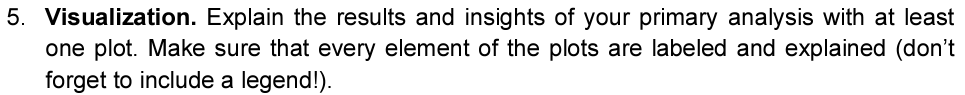

Examine the results and explain how it shows how accurate the machine learning is. Support with graphs and give enough to talk about in the conclusion

**IM NOT SURE IF I VISUALIZED ENOUGH - IF YOU HAVE MORE IDEAS TO VISUALIZE, PLEASE ADD IT TO THIS SECTION**

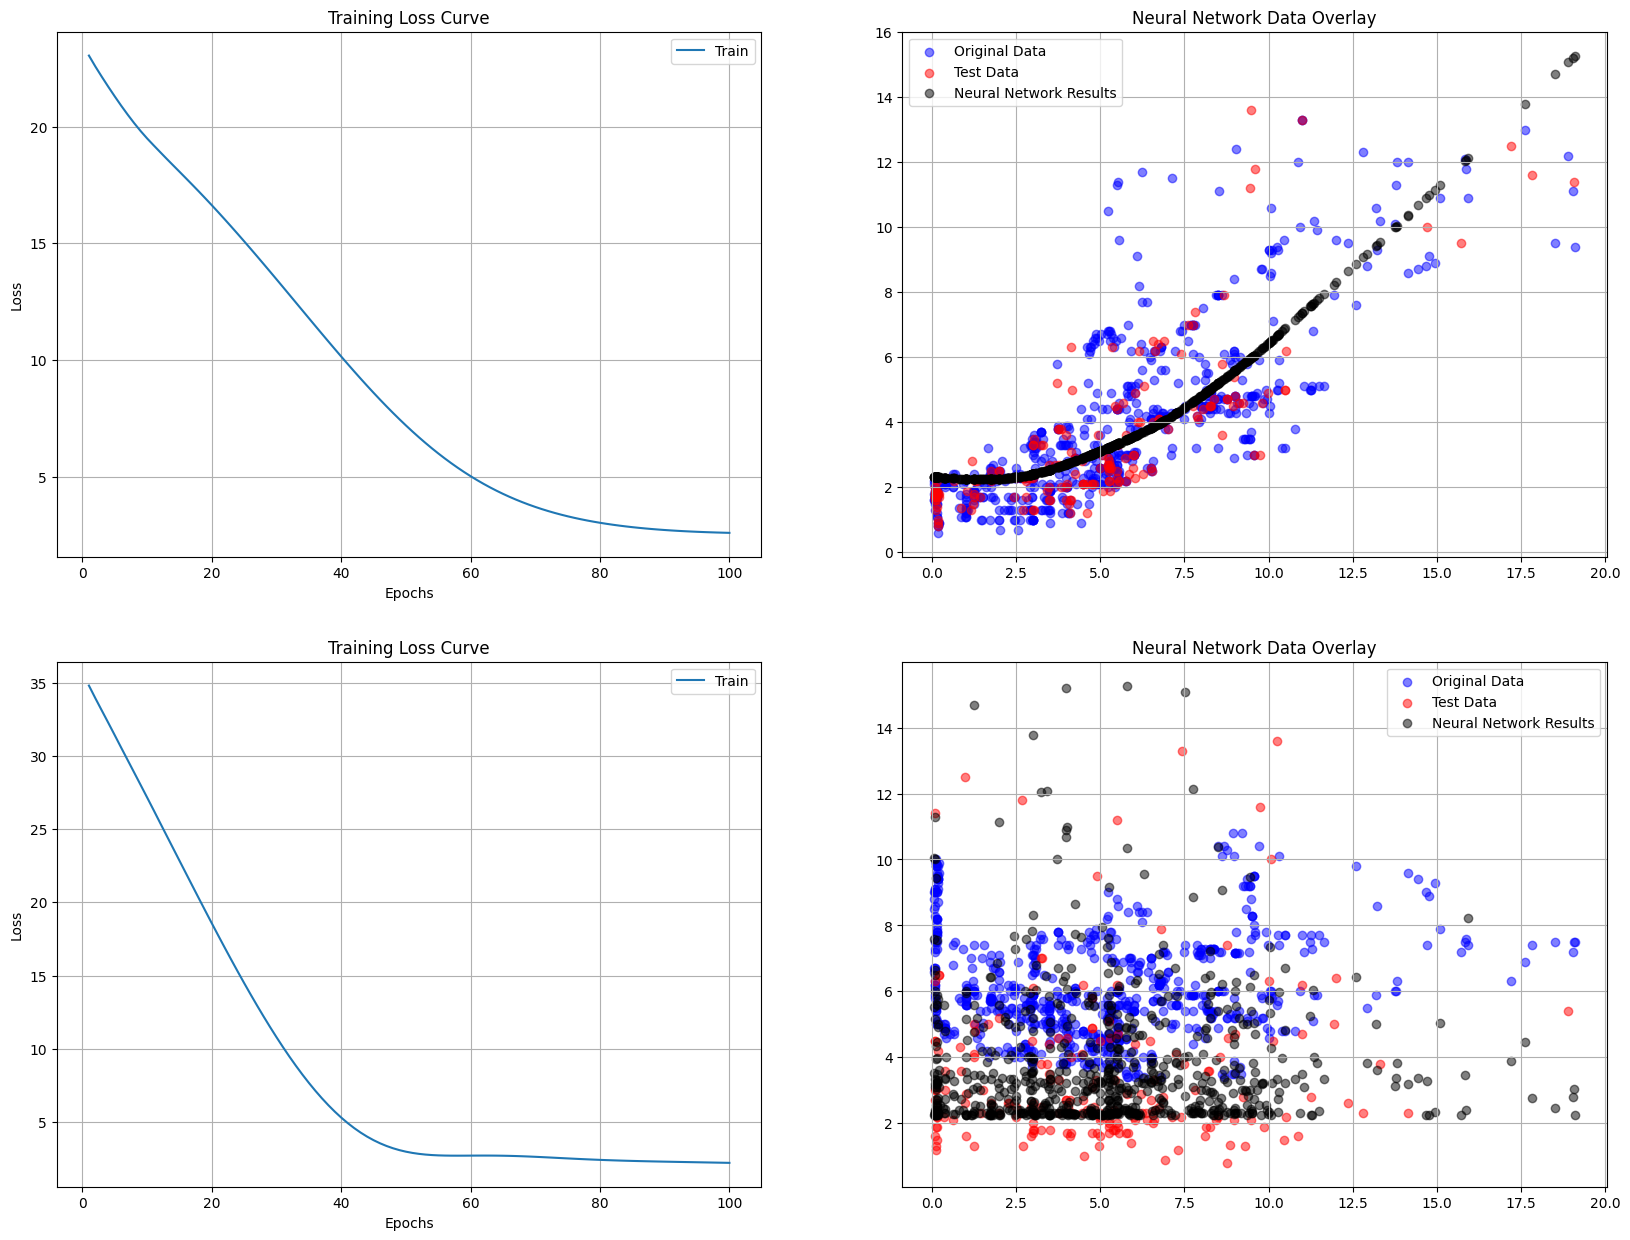

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))

axes[0][0].plot(np.arange(1, num_epochs+1), inf_losses, label='Train')
axes[0][0].set_title('Training Loss Curve')
axes[0][0].set_xlabel('Epochs')
axes[0][0].set_ylabel('Loss')
axes[0][0].legend()
axes[0][0].grid()


axes[0][1].scatter(X_inf_train_nn_stored, y_inf_train_nn,color='blue',label='Original Data',alpha=0.5)
axes[0][1].scatter(X_inf_test_nn_stored, y_inf_test_nn,color='red',label='Test Data',alpha=0.5)
axes[0][1].scatter(X_inf_train_nn_stored,inf_output.detach().numpy(),label='Neural Network Results',alpha=0.5,color='black')
axes[0][1].set_title('Neural Network Data Overlay')
axes[0][1].legend()
axes[0][1].grid()

axes[1][0].plot(np.arange(1, num_epochs+1), unem_losses, label='Train')
axes[1][0].set_title('Training Loss Curve')
axes[1][0].set_xlabel('Epochs')
axes[1][0].set_ylabel('Loss')
axes[1][0].legend()
axes[1][0].grid()


axes[1][1].scatter(X_unem_train_nn_stored, y_unem_train_nn,color='blue',label='Original Data',alpha=0.5)
axes[1][1].scatter(X_unem_test_nn_stored, y_inf_test_nn,color='red',label='Test Data',alpha=0.5)
axes[1][1].scatter(X_unem_train_nn_stored,inf_output.detach().numpy(),label='Neural Network Results',alpha=0.5,color='black') #using scatter here doesnt work...
axes[1][1].set_title('Neural Network Data Overlay')
axes[1][1].legend()
axes[1][1].grid()
plt.show()

At a glance a curious fact is revealed: the graph that was made by the neural network for inflation appears almost exactly the same as the polynomial features with degrees = 2. This lends further credence to our previous idea that there is a linear relationship between unemployment and inflation. As for unemployment, the algorithm has found somewhat of a correlation, it just appears to be shifted along the y-axis by an error rate of 2% or so. Overall, the models are not overfitted since the test datasets do equally well with error.

Though it may seem strange at first glance that the prediction error rate of inflation and unemployment is similar, a closer observation shows why: A great deal of the data points from the Unemployment graph hover close to the loss rate of 2. Thus, the neural network's predictions are mostly consistently off by small margins. In addition to this, the aforementioned vertical trends near the origin, 3 and 5% have been deduced by the network and incorporated into its predictions, leading to much the same outcome. Consequently, it has a relatively low MSE.
One avenue of potential research is to follow up on analyzing the dimensions of each respective neural network. Though it appears as if the neural network responsible for predicting inflation from federal fund rating may have two dimensions, being 'quadratic'; we speculate that the network trained on unemployment may have a far greater number of dimensions responsible for its complex output shape.

Conversely, the inflation correlation graph suffers from a number of extreme outlying values (note the datapoints between x=5.0-10.0 and y=8-14), unlike the relationship between unemployment and fund rates. These two factors drive the MSE close together.

**Conclusion** (To be written after machine learning+visualization)

From the rubric

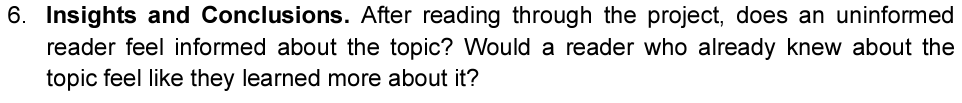